# MNIST: Attaque d'un modèle simple avec FGSM

Le but de ce notebook est d'étudier les paramètres propres à l'attaque et défense:
<table>
    <thead><tr>
        <td>Attaque</td>
        <td>Réseau</td>
        <td>Dataset</td>
        <td>Targeted/Untargeted</td>
        <td>Perturbation</td>
        <td>Statut</td></tr>
    </thead>
    <tr>
        <td>FGSM</td>
        <td>Simple</td>
        <td>MNIST</td>
        <td>Untargeted</td>
        <td>Non controlée</td>
        <td>OK</td></tr>
    <tr>
        <td>FGSM</td>
        <td>Simple</td>
        <td>MNIST</td>
        <td>Untargeted</td>
        <td>Controlée</td>
        <td>OK</td></tr>
    </table>

In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plotAdvOri(original,adversarial):

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original)  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial )  # ::-1 to convert BGR to RGB
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial- original
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

    plt.show()

#plotAdvOri(image/255,adversarial[:, :, ::-1]/255)

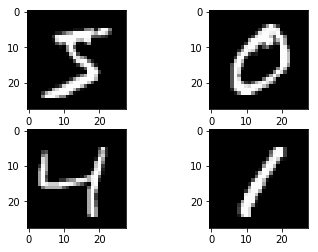

In [3]:
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [4]:
# fix random seed for reproducibility
#seed = 7
#numpy.random.seed(seed)


In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_trainF = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_testF = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [7]:
X_trainF = X_trainF / 255
X_testF = X_testF / 255

In [8]:
# one hot encode outputs
y_trainF = np_utils.to_categorical(y_train)
y_testF = np_utils.to_categorical(y_test)
num_classes = y_testF.shape[1]

In [9]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
print(X_train[0].shape)

(28, 28)


In [11]:
model = baseline_model()
# Fit the model
model.fit(X_trainF, y_trainF, validation_data=(X_testF, y_testF), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_testF, y_testF, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.2797 - acc: 0.9202 - val_loss: 0.1436 - val_acc: 0.9577
Epoch 2/10
 - 3s - loss: 0.1084 - acc: 0.9686 - val_loss: 0.0909 - val_acc: 0.9720
Epoch 3/10
 - 3s - loss: 0.0706 - acc: 0.9795 - val_loss: 0.0834 - val_acc: 0.9736
Epoch 4/10
 - 3s - loss: 0.0494 - acc: 0.9860 - val_loss: 0.0678 - val_acc: 0.9786
Epoch 5/10
 - 3s - loss: 0.0348 - acc: 0.9904 - val_loss: 0.0669 - val_acc: 0.9794
Epoch 6/10
 - 3s - loss: 0.0262 - acc: 0.9928 - val_loss: 0.0593 - val_acc: 0.9813
Epoch 7/10
 - 4s - loss: 0.0194 - acc: 0.9952 - val_loss: 0.0852 - val_acc: 0.9739
Epoch 8/10
 - 3s - loss: 0.0136 - acc: 0.9973 - val_loss: 0.0608 - val_acc: 0.9807
Epoch 9/10
 - 3s - loss: 0.0106 - acc: 0.9979 - val_loss: 0.0578 - val_acc: 0.9825
Epoch 10/10
 - 3s - loss: 0.0089 - acc: 0.9981 - val_loss: 0.0624 - val_acc: 0.9802
Baseline Error: 1.98%


In [12]:
model.save('my_model.h5')
#model = load_model('my_model.h5')

In [13]:
df= pd.DataFrame(y_trainF)
df.head(12)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X_testF.shape


(10000, 784)

In [15]:
#_,(images, labels) = mnist.load_data()
images = X_test.reshape(10000,28,28,1)
images= images.astype('float32')
images /= 255
labels=y_test

(28, 28)


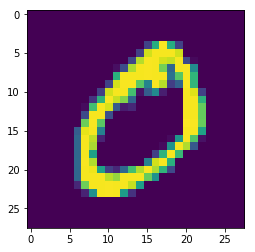

In [16]:
print(X_train[1].shape)
plt.imshow(X_trainF[0].reshape(28,28))
plt.imshow(X_trainF[1].reshape(28,28))
plt.show()

In [17]:
print(images[1].shape)
print(y_train[1])
gmodel = foolbox.models.KerasModel(model, bounds=(0, 1))


(28, 28, 1)
0


In [18]:
attackM = foolbox.attacks.FGSM(gmodel)
adversarialM = attackM(images[0].reshape(784), labels[0])

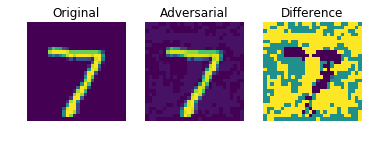

In [19]:
plotAdvOri(images[0].reshape(28,28),adversarialM.reshape(28,28))

In [20]:
adversarialMM =adversarialM.reshape(1,784)


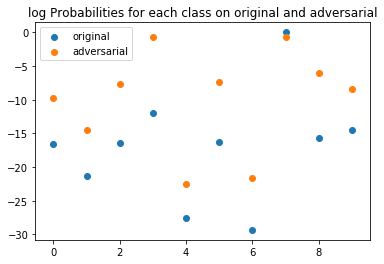

In [21]:
 #reshaping it for model prediction
model_predictions_original = model.predict(images[0].reshape(1,784))
model_predictions_adversarial = model.predict(adversarialMM)
#print(model_predictions_adversarial)

plt.scatter(np.arange(10), np.log(model_predictions_original), label="original")
plt.scatter(np.arange(10), np.log(model_predictions_adversarial), label="adversarial")
plt.legend()
plt.title("log Probabilities for each class on original and adversarial")
plt.show()

On voit ici que pour l'original la prediction était 7 qui correspondait bien à l'image. La deuxième plus forte probabilité pour l'original est 3. Le FGSM a donc permis d'augmenter cette deuxième probabilité pour qu'elle surpasse (tout juste) la probabilité que l'adversarial soit un 7.

In [22]:
model_prediction_class = model.predict_classes(adversarialMM)
print("from {} to {}".format(str(labels[0]),str(model_prediction_class)))

from 7 to [3]


In [23]:
diff=images[0].reshape(784)-adversarialM
dist = np.linalg.norm(diff)
print("Compare original image and adversarial L2: {} L0: {}".format(np.linalg.norm(diff), np.linalg.norm(diff, ord=0)))

Compare original image and adversarial L2: 1.10088050365448 L0: 495.0


In [24]:
dist2 = np.linalg.norm(images[0].reshape(784)-images[1].reshape(784))
diff2=images[0].reshape(784)-images[1].reshape(784)
#print(dist2)
print("Compare image 0 (7) and 1 (2) L2: {} L0: {}".format(np.linalg.norm(diff2), np.linalg.norm(diff2, ord=0)))

Compare image 0 (7) and 1 (2) L2: 11.268815994262695 L0: 243.0


On voit ici que pour le fgsm L2 est plus judicieux par rapport à L0

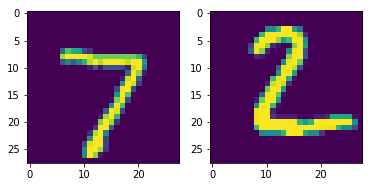

In [25]:
plt.subplot(121)
plt.imshow(images[0].reshape(28,28))
plt.subplot(122)
plt.imshow(images[1].reshape(28,28))

In [62]:
class imgAttack():
    def __init__(self, model):
        self.img_original = None
        self.img_adversarial = None
        self.prediction_class_original=None
        self.prediction_class_adversarial=None
        self.predictions_original=None
        self.predictions_adversarial=None
        self.diff=None
        self.dist=None
        self.model=model
    def fill(self, img_original,img_adversarial):
        self.prediction_class_original=self.model.predict_classes(img_original.reshape(1,784))
        self.prediction_class_adversarial=self.model.predict_classes(img_adversarial.reshape(1,784))
        self.predictions_original=self.model.predict(img_original.reshape(1,784))
        self.predictions_adversarial=self.model.predict(img_adversarial.reshape(1,784))
        self.diff=img_original.reshape(784)-img_adversarial
        self.dist= np.linalg.norm(diff)
        self.img_original=img_original
        self.img_adversarial=img_adversarial
        



In [63]:
adv_X_test=[]
imgAttacks=[]

In [64]:

for img, label in zip(images.reshape(10000, 784), labels):
    adversarialM = attackM(img, label)
    imgAttack1=imgAttack(model)
    imgAttack1.fill(img,adversarialM)
    imgAttacks.append(imgAttack1)

/anaconda3/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [90]:
df_attacksFGSM= pd.DataFrame([vars(f) for f in imgAttacks])
df_attacksFGSM.head()

,diff,dist,img_adversarial,img_original,model,prediction_class_adversarial,prediction_class_original,predictions_adversarial,predictions_original
0,"[-0.05, -0.05, -0.05, -0.05, 0.0, 0.0, -0.05, ...",2.178828,"[0.05, 0.05, 0.05, 0.05, 0.0, 0.0, 0.05, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<keras.engine.sequential.Sequential object at ...,[3],[7],"[[5.5026154e-05, 4.803903e-07, 0.00044326746, ...","[[6.241464e-08, 5.1091437e-10, 6.8234435e-08, ..."
1,"[-0.088, 0.0, -0.088, -0.088, -0.088, 0.0, 0.0...",2.178828,"[0.088, 0.0, 0.088, 0.088, 0.088, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<keras.engine.sequential.Sequential object at ...,[1],[2],"[[1.4165728e-06, 0.49961162, 0.4993651, 0.0001...","[[1.5271153e-09, 2.3668392e-06, 0.9999976, 2.3..."
2,"[-0.042, -0.042, 0.0, 0.0, 0.0, -0.042, -0.042...",2.178828,"[0.042, 0.042, 0.0, 0.0, 0.0, 0.042, 0.042, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<keras.engine.sequential.Sequential object at ...,[8],[1],"[[6.2154206e-05, 0.4688987, 0.028566334, 0.000...","[[1.314088e-07, 0.9997528, 5.1175717e-05, 1.59..."
3,"[0.0, -0.195, 0.0, -0.195, 0.0, 0.0, -0.195, -...",2.178828,"[0.0, 0.195, 0.0, 0.195, 0.0, 0.0, 0.195, 0.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<keras.engine.sequential.Sequential object at ...,[9],[0],"[[0.4989516, 4.408252e-13, 1.1531336e-06, 1.24...","[[1.0, 1.9534476e-11, 7.1165194e-09, 1.4548841..."
4,"[-0.025, 0.0, -0.025, 0.0, 0.0, -0.025, -0.025...",2.178828,"[0.025, 0.0, 0.025, 0.0, 0.0, 0.025, 0.025, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<keras.engine.sequential.Sequential object at ...,[9],[4],"[[7.845592e-06, 5.0798e-08, 2.5736144e-05, 1.7...","[[1.2861416e-07, 3.030192e-09, 4.914825e-07, 1..."


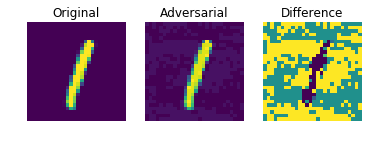

In [66]:
plotAdvOri(imgAttacks[5].img_original.reshape(28,28),imgAttacks[5].img_adversarial.reshape(28,28))

## Voyons comment se sont comporté les probabilités pour les 15 premières attaques

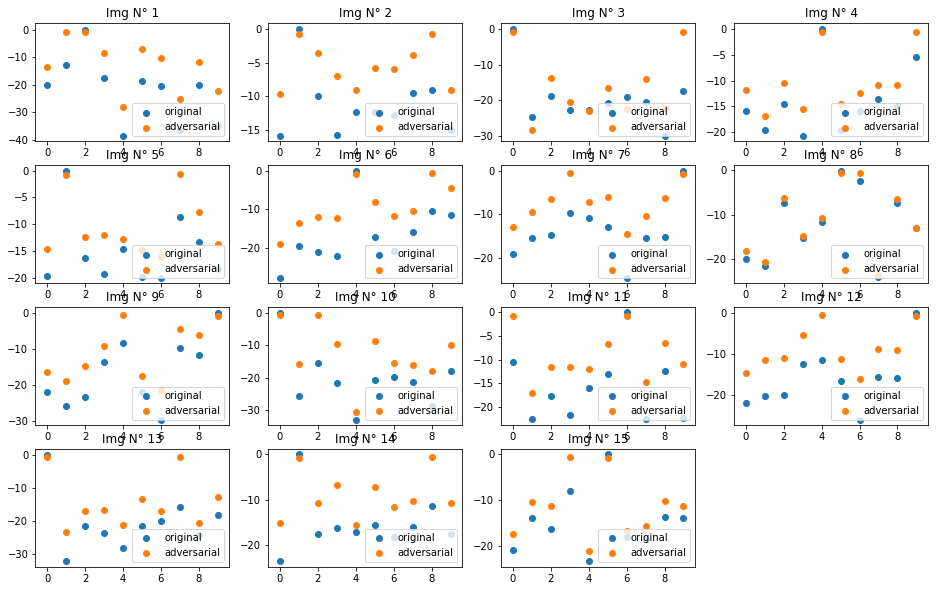

In [89]:
f = plt.figure(figsize=(16,10))


for i in range(1, 16):
    plt.subplot(4, 4, i)
    plt.scatter(np.arange(10), np.log(imgAttacks[i].predictions_original), label="original")
    plt.scatter(np.arange(10), np.log(imgAttacks[i].predictions_adversarial), label="adversarial")
    plt.legend(loc=4)
    plt.title("Img N° {}".format(i))

#plt.title("log Probabilities for each class on original and adversarial", loc="right")


plt.show()


## Et maintenant est ce que les perturbation sont visibles à l'oeil humain?

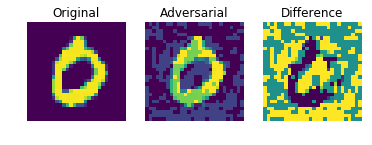

In [86]:
attackEps = foolbox.attacks.FGSM(gmodel)
adversarialMExp = attackEps(images[3].reshape(784), labels[3],max_epsilon= )
imgAttack1Exp=imgAttack(model)
imgAttack1Exp.fill(images[3],adversarialMExp)
    
plotAdvOri(imgAttack1Exp.img_original.reshape(28,28),imgAttack1Exp.img_adversarial.reshape(28,28))

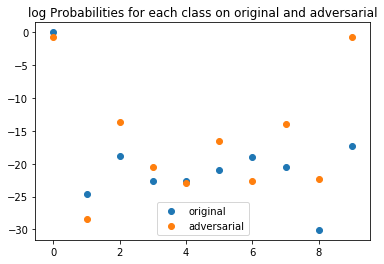

In [87]:
 #reshaping it for model prediction
#model_predictions_original = model.predict(images[0].reshape(1,784))
#model_predictions_adversarial = model.predict(adversarialMM)
#print(model_predictions_adversarial)

plt.scatter(np.arange(10), np.log(model.predict(images[3].reshape(1,784))), label="original")
plt.scatter(np.arange(10), np.log( model.predict(adversarialMExp.reshape(1,784))), label="adversarial")
plt.legend()
plt.title("log Probabilities for each class on original and adversarial")
plt.show()